# 📋 ATML PA4 - Task 4.1: Implementing FedProx

In this task, we will implement the **Federated Proximal (FedProx)** algorithm. This algorithm extends FedAvg to better handle statistical heterogeneity (non-IID data) by adding a proximal term to the local client loss function.

**Goal:** Compare FedAvg (which is just FedProx with `μ=0`) against FedProx with various `μ` values on both a mildly heterogeneous (nearly IID) dataset and a highly heterogeneous (non-IID) dataset.

We will use the `load_cifar10_noniid_dirichlet` function to create our non-IID data partitions.

## **Part 1: Environment Setup**

### **1.1. Imports and Configuration**

First, we import all necessary libraries and our functions from `federated_learning.py`. We also define the main configuration parameters for the experiments.

In [1]:
# ============================================
# 📦 Imports and Environment Setup
# ============================================
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

# --- Add path to federated_learning.py ---
# You specified that federated_learning.py is in ../../FedAvg
fed_avg_path = os.path.abspath(os.path.join(os.getcwd(), "../../FedAvg"))

if fed_avg_path not in sys.path:
    print(f"Adding path: {fed_avg_path}")
    sys.path.append(fed_avg_path)
else:
    print(f"Path already in sys.path: {fed_avg_path}")
# -----------------------------------------

try:
    from federated_learning import (federated_train,
                                    load_cifar10_noniid_dirichlet)

    print("Successfully imported federated_learning module.")
except ImportError:
    print(f"Error: 'federated_learning.py' not found in path: {fed_avg_path}")
    print("Please ensure the path is correct and the file exists.")
    # sys.exit(1) # This might stop the notebook kernel

# ============================================
# ⚙️ Main Configuration
# ============================================
print("Configuring experiment...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NUM_CLIENTS = 10
NUM_ROUNDS = 50
LEARNING_RATE = 0.01
BATCH_SIZE = 32
SEED = 42

# ============================================
# ⚙️ Control Flag
# ============================================
FORCE_RETRAIN = False  # Set to True to re-run all training
print(f"FORCE_RETRAIN set to: {FORCE_RETRAIN}")

Adding path: /root/IbsATML/FedAvg
Successfully imported federated_learning module.
Configuring experiment...
Using device: cuda
FORCE_RETRAIN set to: False


### **1.2. Directory Setup**

We create the directories to store our JSON results, plots, and saved models for this task.

In [2]:
# ============================================
# 📂 Directory Setup
# ============================================
PLOT_DIR = 'plots/task4_1'
JSON_DIR = 'json_results/task4_1'
MODEL_DIR = 'pth_models/task4_1'

os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(JSON_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Results will be saved in: {JSON_DIR}")
print(f"Plots will be saved in: {PLOT_DIR}")
print(f"Models will be saved in: {MODEL_DIR}")

Results will be saved in: json_results/task4_1
Plots will be saved in: plots/task4_1
Models will be saved in: pth_models/task4_1


## **Part 2: Experiment Configuration**

### **2.1. Define Experiment Scenarios**

We define two dictionaries:
1.  `heterogeneity_levels`: Specifies the data distribution (mild vs. high skew) and the number of local epochs (K).
2.  `experiments`: Specifies the algorithms to run, defined by their `μ` parameter. FedAvg is the baseline with `μ=0`.

In [3]:
# ============================================
# 🔬 Experiment Definitions
# ============================================

# Define the different FedProx `mu` values to test
experiments = {
    'FedAvg_baseline': {'mu': 0.0},
    'FedProx_mu0.001': {'mu': 0.001},
    'FedProx_mu0.01': {'mu': 0.01},
    'FedProx_mu0.1': {'mu': 0.1},
}

# Define the heterogeneity scenarios
heterogeneity_levels = {
    'Mild_Heterogeneity': {'alpha': 100, 'K': 5},  # Nearly IID
    'High_Heterogeneity': {'alpha': 0.1, 'K': 5},  # Highly non-IID
}

# Store all results in this dictionary
all_results = {}

print("Defined experiment scenarios:")
print(f"Heterogeneity levels: {list(heterogeneity_levels.keys())}")
print(f"Algorithms (by mu): {list(experiments.keys())}")

Defined experiment scenarios:
Heterogeneity levels: ['Mild_Heterogeneity', 'High_Heterogeneity']
Algorithms (by mu): ['FedAvg_baseline', 'FedProx_mu0.001', 'FedProx_mu0.01', 'FedProx_mu0.1']


## **Part 3: Main Experiment Loop**

Now we run the experiments. We loop through each heterogeneity level, load the corresponding non-IID data *once*, and then run all algorithm (all `μ` values) on that same data split for a fair comparison.

We use `client_fraction=1.0` and `K=5` as specified in the roadmap.

In [4]:
# ============================================
# 🚀 Main Experiment Loop
# ============================================

for het_name, het_config in heterogeneity_levels.items():
    alpha = het_config["alpha"]
    K = het_config["K"]

    # Check if results already exist
    json_name = f"results_{het_name}.json"
    json_path = os.path.join(JSON_DIR, json_name)

    if os.path.exists(json_path) and not FORCE_RETRAIN:
        print(f"\n{'='*70}")
        print(f"📂 Loading existing results for: {het_name}")
        print(f"{'='*70}\n")

        with open(json_path, "r") as f:
            het_results = json.load(f)

        all_results[het_name] = het_results
        print(f"✅ Loaded {len(het_results)} experiment results from {json_path}")
        continue  # Skip to next heterogeneity level

    # If we reach here, we need to train
    print(f"\n{'='*70}")
    print(f"🔥 Running experiments for: {het_name} (α={alpha}, K={K})")
    print(f"{'='*70}\n")

    # 1. Create non-IID data ONCE for this heterogeneity level
    print(f"Loading non-IID data (alpha={alpha})...")
    train_loaders, test_loader, client_sizes = load_cifar10_noniid_dirichlet(
        num_clients=NUM_CLIENTS, alpha=alpha, batch_size=BATCH_SIZE, seed=SEED
    )
    print("Data loaded.")

    het_results = {}

    # 2. Loop through each algorithm (mu value) and run training
    for exp_name, exp_config in experiments.items():
        mu = exp_config["mu"]

        print(f"\n--- Running: {exp_name} (μ={mu}) ---")

        model, history = federated_train(
            num_clients=NUM_CLIENTS,
            num_rounds=NUM_ROUNDS,
            local_epochs=K,
            client_fraction=1.0,
            lr=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            device=device,
            seed=SEED,
            mu=mu,
            train_loaders=train_loaders,
            test_loader=test_loader,
            client_sizes=client_sizes,
        )

        het_results[exp_name] = history

        # 3. Save model checkpoint
        model_name = f"model_{het_name}_{exp_name}.pth"
        model_path = os.path.join(MODEL_DIR, model_name)
        torch.save(model.state_dict(), model_path)
        print(f"Saved model to {model_path}")

    # 4. Store results for this heterogeneity level
    all_results[het_name] = het_results

    # 5. Save results JSON after each heterogeneity level is complete
    with open(json_path, "w") as f:
        json.dump(het_results, f, indent=4)
    print(f"\n💾 Saved results for {het_name} to {json_path}")


print("\n" + "=" * 70)
print("✅ All experiments complete.")
print("=" * 70)


📂 Loading existing results for: Mild_Heterogeneity

✅ Loaded 4 experiment results from json_results/task4_1/results_Mild_Heterogeneity.json

📂 Loading existing results for: High_Heterogeneity

✅ Loaded 4 experiment results from json_results/task4_1/results_High_Heterogeneity.json

✅ All experiments complete.


## **Part 4: Plotting and Analysis**

### **4.1. Generate Comparison Plots**

We now plot the results. For each heterogeneity level, we create a side-by-side comparison of **Test Accuracy** and **Client Drift** for all algorithms.

Generating comparison plots...
Saved plot to plots/task4_1/plot_Mild_Heterogeneity_comparison.png


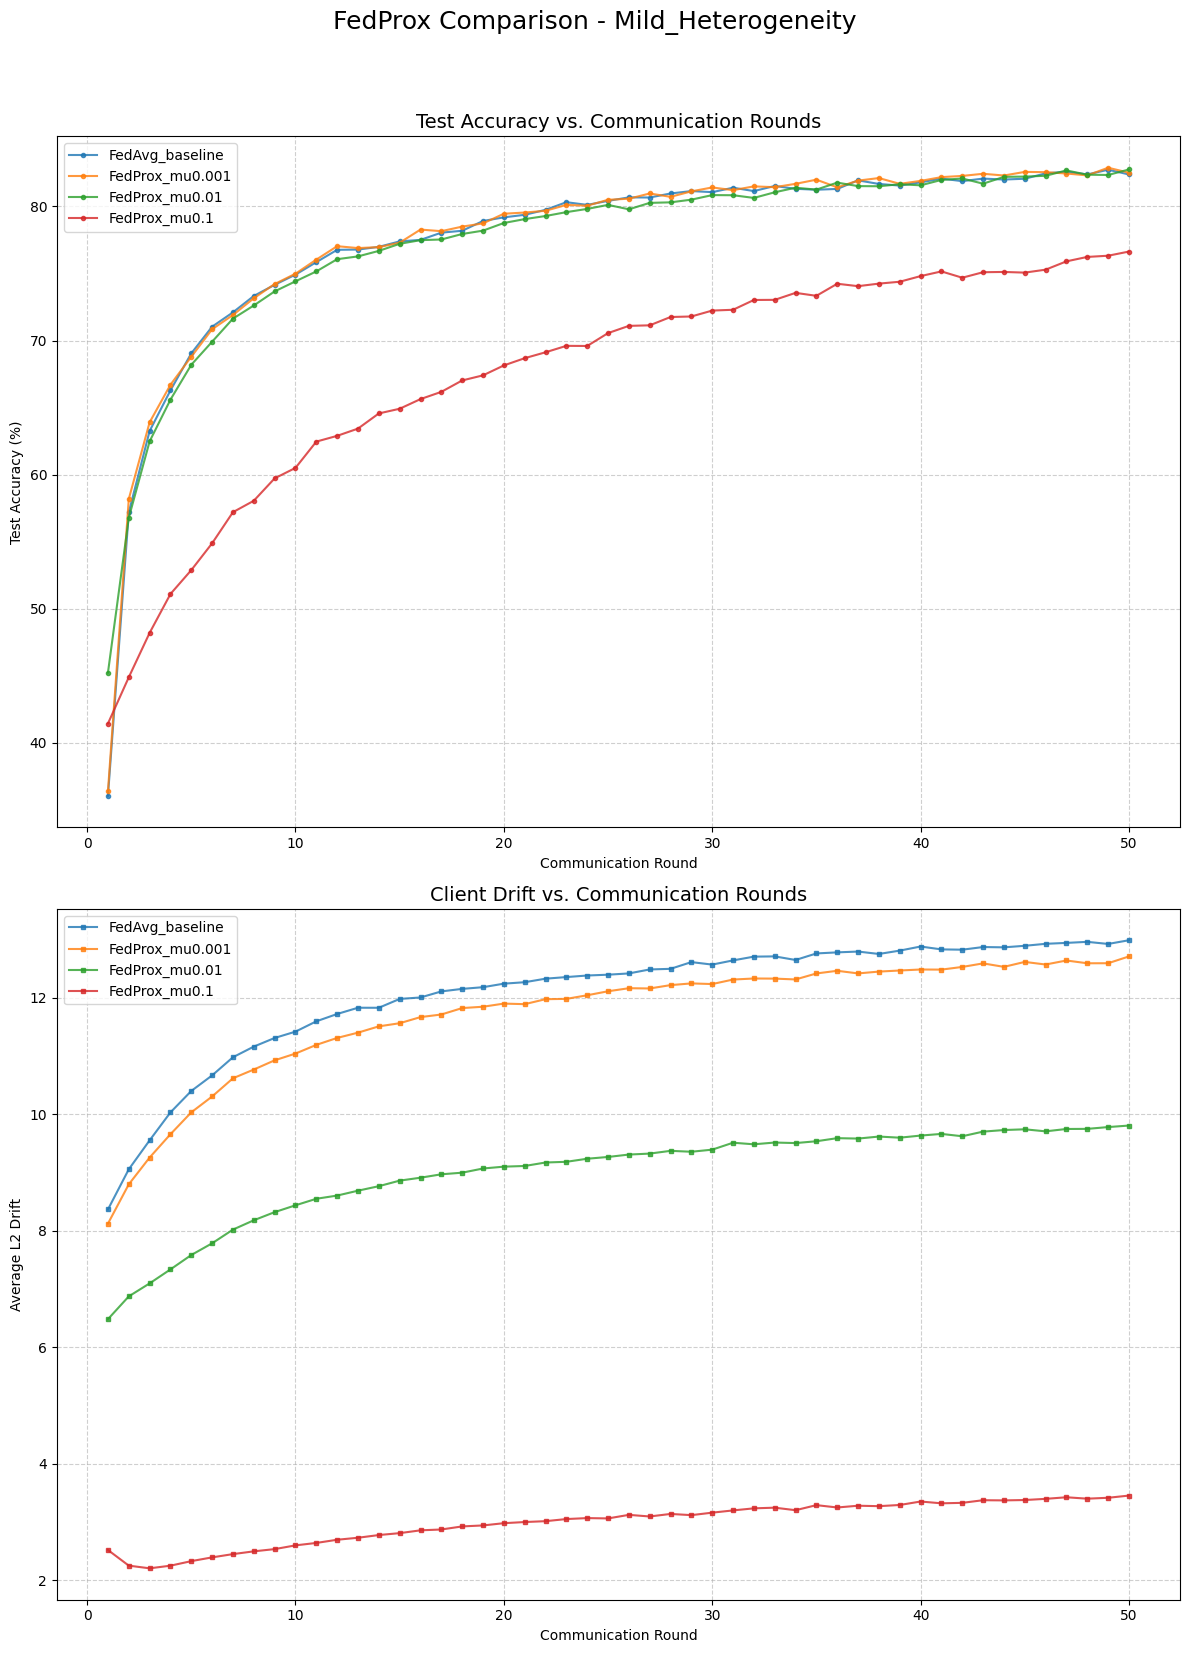

Saved plot to plots/task4_1/plot_High_Heterogeneity_comparison.png


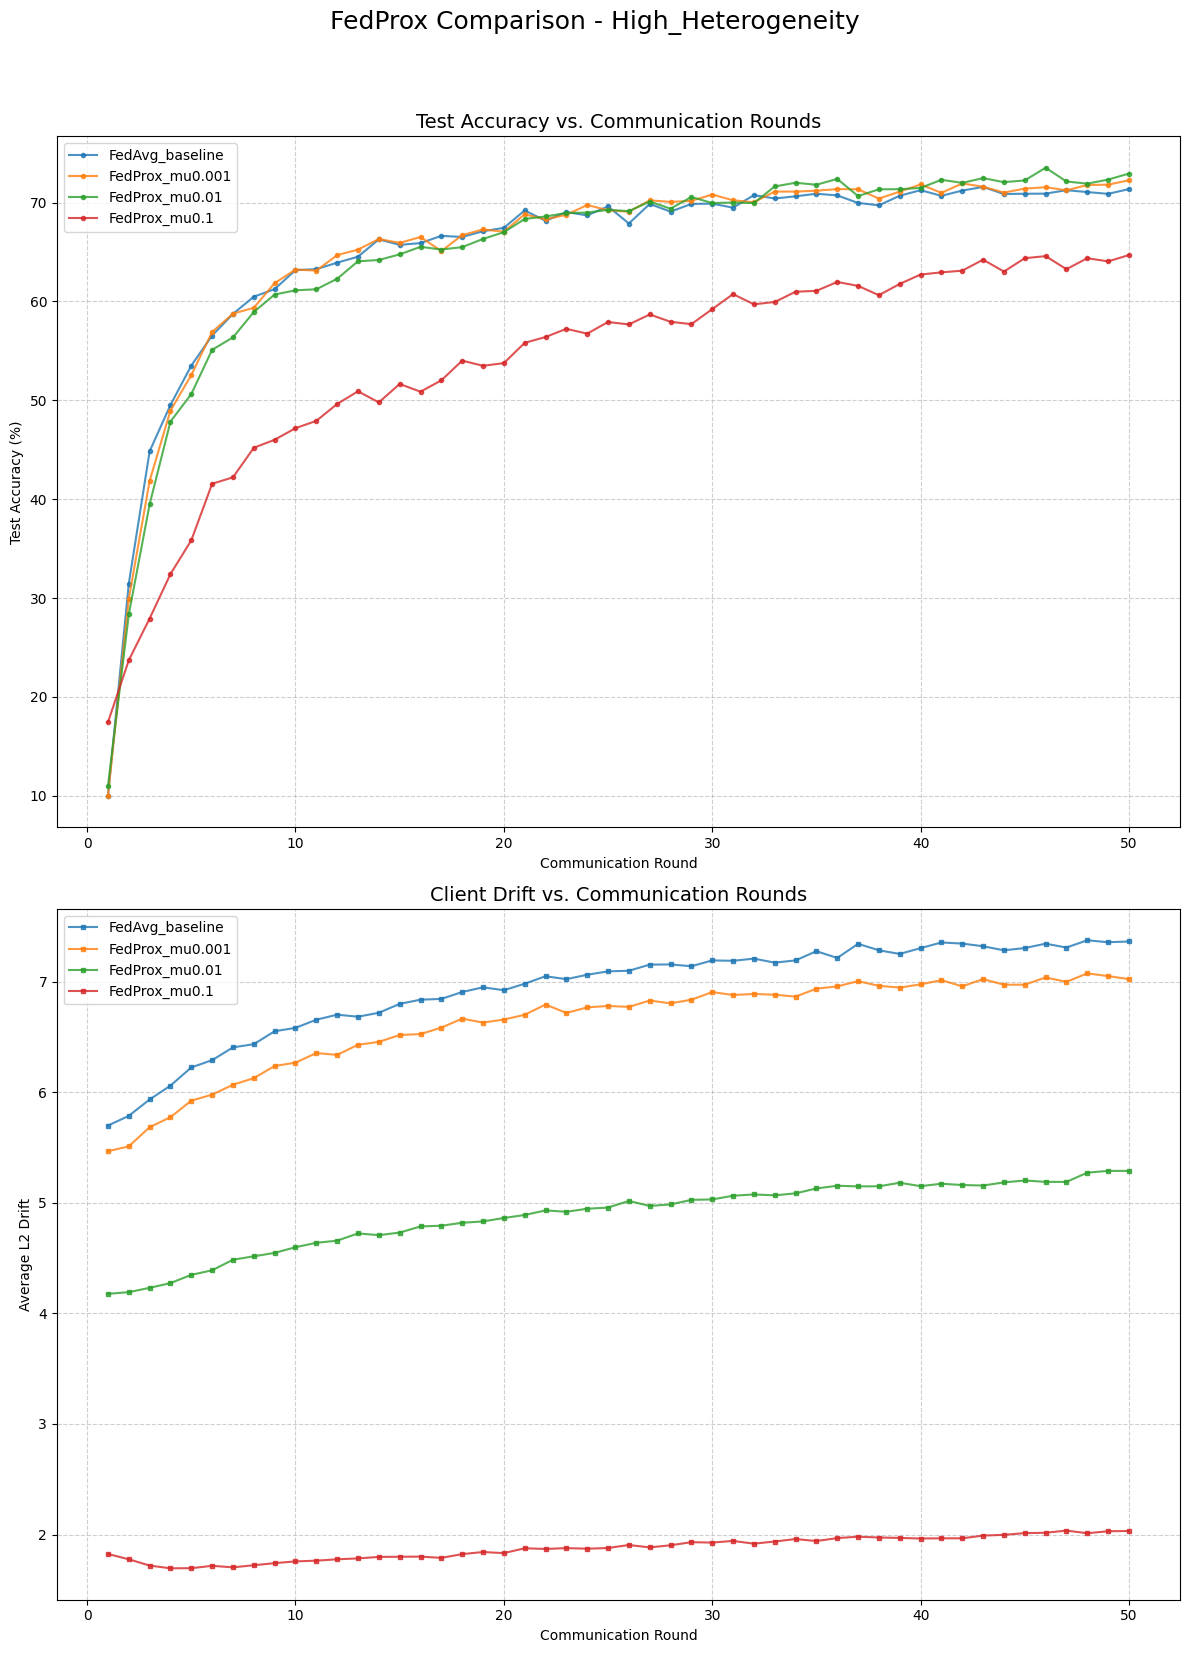

In [5]:
# ============================================
# 📊 Plotting Results
# ============================================
print("Generating comparison plots...")

for het_name in heterogeneity_levels.keys():
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))
    fig.suptitle(f'FedProx Comparison - {het_name}', fontsize=18, y=1.03)
    
    results = all_results[het_name]
    
    # --- Plot 1: Test Accuracy ---
    axes[0].set_title('Test Accuracy vs. Communication Rounds', fontsize=14)
    axes[0].set_xlabel('Communication Round')
    axes[0].set_ylabel('Test Accuracy (%)')
    
    for exp_name, history in results.items():
        axes[0].plot(history['rounds'], history['test_acc'], 
                     label=exp_name, marker='o', markersize=3, alpha=0.8)
    
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)
    
    # --- Plot 2: Client Drift ---
    axes[1].set_title('Client Drift vs. Communication Rounds', fontsize=14)
    axes[1].set_xlabel('Communication Round')
    axes[1].set_ylabel('Average L2 Drift')
    
    for exp_name, history in results.items():
        axes[1].plot(history['rounds'], history['client_drift'], 
                     label=exp_name, marker='s', markersize=3, alpha=0.8)
    
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    # --- Save and Show Plot ---
    plt.tight_layout()
    plot_name = f'plot_{het_name}_comparison.png'
    plot_path = os.path.join(PLOT_DIR, plot_name)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Saved plot to {plot_path}")
    plt.show()


### **4.2. Create Summary Table**

Finally, we'll generate a summary table using `pandas` to show the key final metrics, as outlined in the roadmap. This helps in quickly comparing the performance for the report.

In [6]:
# ============================================
# 📈 Analysis & Summary Table
# ============================================
print("\n" + "="*70)
print("📊 Summary Table")
print("="*70)

summary_data = []

for het_name, results in all_results.items():
    for exp_name, history in results.items():
        summary_data.append({
            'Scenario': het_name,
            'Algorithm': exp_name,
            'μ': experiments[exp_name]['mu'],
            'Final Accuracy (%)': history['test_acc'][-1],
            'Final Drift': history['client_drift'][-1],
            'Avg Accuracy (last 10 rounds)': np.mean(history['test_acc'][-10:]),
            'Std Dev (last 10 rounds)': np.std(history['test_acc'][-10:])
        })

summary_df = pd.DataFrame(summary_data)

# Display the table in markdown format for easy copy-pasting
print(summary_df.to_markdown(index=False, floatfmt=".3f"))

print("\n--- Analysis complete. ---")


📊 Summary Table
| Scenario           | Algorithm       |     μ |   Final Accuracy (%) |   Final Drift |   Avg Accuracy (last 10 rounds) |   Std Dev (last 10 rounds) |
|:-------------------|:----------------|------:|---------------------:|--------------:|--------------------------------:|---------------------------:|
| Mild_Heterogeneity | FedAvg_baseline | 0.000 |               82.390 |        12.989 |                          82.272 |                      0.269 |
| Mild_Heterogeneity | FedProx_mu0.001 | 0.001 |               82.520 |        12.711 |                          82.455 |                      0.190 |
| Mild_Heterogeneity | FedProx_mu0.01  | 0.010 |               82.760 |         9.807 |                          82.267 |                      0.297 |
| Mild_Heterogeneity | FedProx_mu0.1   | 0.100 |               76.640 |         3.453 |                          75.555 |                      0.631 |
| High_Heterogeneity | FedAvg_baseline | 0.000 |               71.360 |      